In [4]:
from sunnybrook import load_data 
import os


loaded_train_x, loaded_train_y = load_data(
    '/sunnybrook/train',
    'i',
    crop_size=128,
)

loaded_train_x.shape, loaded_train_y.shape

/usr/local/lib/python3.5/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


((260, 128, 128, 1), (260, 128, 128, 1))

<Figure size 432x288 with 0 Axes>

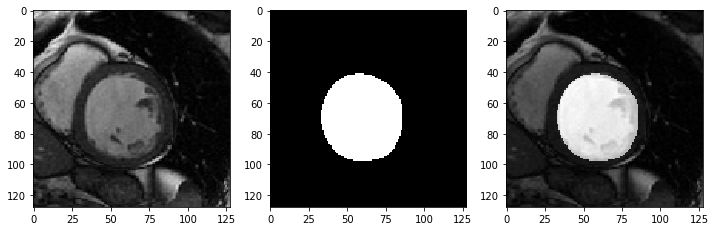

In [19]:
import matplotlib.pyplot as plt
import numpy as np

img = loaded_train_x[0, :, :, 0]
mask = loaded_train_y[0, :, :, 0]

img = img / np.max(img)

plt.clf()
plt.figure(figsize=(12, 12))

plt.subplot(131)
plt.imshow(img, cmap='gray')
plt.subplot(132)
plt.imshow(mask, cmap='gray')
plt.subplot(133)
plt.imshow((img + mask) / 2, cmap='gray')

In [20]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from itertools import islice

#from fcn_model import fcn_model
from fcn_model import fcn_model
from gridnet_model import gridnet_model

from helpers import lr_poly_decay, get_SAX_SERIES

from sunnybrook.contour import load_all_contours, export_all_contours
from skimage import io, color

DIR_DATA = './data'


def _to_image(output):
    arr = np.asarray(output)
    normalized = arr / np.max(arr)
    return (
        normalized
        if normalized.shape[-1] != 1
        else np.reshape(normalized, normalized.shape[:-1])
    )


def predict_and_save(model, images, *, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    predictions = model.predict(images)
    for i, (image, prediction) in enumerate(zip(images, predictions)):
        prediction = prediction[:, :, 1]
        
        image_path = os.path.join(output_dir, 'img_{}.png'.format(i))
        prediction_path = os.path.join(output_dir, 'pred_{}.png'.format(i))

        io.imsave(image_path, _to_image(image))
        io.imsave(prediction_path, _to_image(prediction))



In [10]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

from itertools import islice

from helpers import lr_poly_decay

from sklearn.model_selection import KFold, cross_val_score
from gridnet_model import gridnet_model

def get_image_flow(images, batch_size=None, seed=None, **kwargs):
    image_datagen = ImageDataGenerator(**kwargs)
    return image_datagen.flow(
        images,
        shuffle=False,
        batch_size=batch_size,
        seed=seed,
    )
    
    
crop_size = 128
batch_size = 1
epoch_count = 42
seed = 42

input_shape = (crop_size, crop_size, 1)
num_classes = 2

m = gridnet_model

model = m(input_shape, num_classes)

kwargs = dict(
    rotation_range=180,
    zoom_range=0.0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    horizontal_flip=True,
    vertical_flip=True,
)

kfold = KFold(n_splits=3)

for index, (train, test) in enumerate(kfold.split(loaded_train_x)):
    print()
    print('KFold: {}'.format(index))
    
    train_x = loaded_train_x[train]
    train_y = loaded_train_y[train]
    test_x = loaded_train_x[test]
    test_y = loaded_train_y[test]

    train_data = zip(
        get_image_flow(train_x, batch_size=batch_size, seed=seed, **kwargs),
        get_image_flow(train_y, batch_size=batch_size, seed=seed, **kwargs),
    )
    
    max_iter = int(len(train_x) / batch_size * epoch_count)
    iter_count = int(len(train_x) / batch_size)
    curr_iter = 0
    base_lr = K.eval(model.optimizer.lr)
    learning_rate = lr_poly_decay(model, base_lr, curr_iter, max_iter, power=0.5)
    
    for epoch in range(1, epoch_count + 1):
        print()
        print('Main Epoch {:d}'.format(epoch))
        print('Learning rate: {:6f}'.format(learning_rate))
        train_result = []

        for img, mask in islice(train_data, batch_size):
            res = model.train_on_batch(img, mask)
            curr_iter += 1
            learning_rate = lr_poly_decay(model, base_lr, curr_iter,
                                          max_iter, power=0.5)
            train_result.append(res)

        train_result = np.asarray(train_result)
        train_result = np.mean(train_result, axis=0).round(decimals=10)

        print('Train result {}:'.format(model.metrics_names))
        print(train_result)
        print()
        print('Evaluating val set ...')
    
        test_result = model.evaluate(test_x, test_y, batch_size=32)
        test_result = np.round(test_result, decimals=10)

        print()
        print('Val set result {}:'.format(model.metrics_names))
        print(test_result)

        save_file = '_'.join([
            'sunnybrook',
            contour_type,
            'epoch',
            str(epoch),
        ]) + '.h5'

        logs_dir = os.path.join(DIR_DATA, 'model_logs')
        os.makedirs(logs_dir, exist_ok=True)
        save_path = os.path.join(logs_dir, save_file)

        print()
        print('Saving model weights to {}'.format(save_path))

        # model.save_weights(save_path)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_136 (Conv2D)             (None, 128, 128, 64) 640         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_137 (Conv2D)             (None, 128, 128, 64) 36928       conv2d_136[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 64, 64, 64)   0           conv2d_137[0][0]                 
__________________________________________________________________________________________________
conv2d_140


Main Epoch 1
Learning rate: 0.001000


ResourceExhaustedError: OOM when allocating tensor with shape[1,1024,8,8]
	 [[Node: conv2d_153/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_152/Relu, conv2d_153/kernel/read)]]
	 [[Node: metrics_5/_dice_metric_2d/Mean_1/_1251 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_3543_metrics_5/_dice_metric_2d/Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'conv2d_153/convolution', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-e3108ae96e68>", line 32, in <module>
    model = m(input_shape, num_classes)
  File "/root/cardiac-segm/gridnet_model.py", line 108, in gridnet_model
    conv_5_2 = Conv2D(1024, 3, **kwargs)(conv_5_1)
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/keras/layers/convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 3335, in conv2d
    data_format=tf_data_format)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 751, in convolution
    return op(input, filter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 835, in __call__
    return self.conv_op(inp, filter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 499, in __call__
    return self.call(inp, filter)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 187, in __call__
    name=self.name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 631, in conv2d
    data_format=data_format, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1,1024,8,8]
	 [[Node: conv2d_153/convolution = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_152/Relu, conv2d_153/kernel/read)]]
	 [[Node: metrics_5/_dice_metric_2d/Mean_1/_1251 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_3543_metrics_5/_dice_metric_2d/Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
